In [78]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import random
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import torch.nn.functional as F
import copy

#### Firstly, define some common functions to make things easier in the future

In [2]:
# pyTorch neural network class

class MyPytorchNetwork(nn.Module):
    def __init__(self, layers, activation):
        super(MyPytorchNetwork, self).__init__()
        self.activation = activation
        self.fc_layers = nn.ModuleList([nn.Linear(layers[i], layers[i + 1]) for i in range(len(layers) - 1)])

    def forward(self, x):
        x = torch.flatten(x, 1)

        # TODO: I'm using relus everywhere for now, we need to change it to be adjustable
        for layer in self.fc_layers[:-1]:
            if self.activation == 'linear':
                x = layer(x)
            elif self.activation == 'relu':
                x = F.relu(layer(x))
            elif self.activation == 'sigmoid':
                x = torch.sigmoid(layer(x))
            elif self.activation == 'tanh':
                x = torch.tanh(layer(x))
            else:
                raise ValueError(f"Activation funtion {self.activation} is invalid")

        # Always sigmoid on the last lauer
        return torch.sigmoid(self.fc_layers[-1](x))


def train_torch_network(network: MyPytorchNetwork, dataset, max_epochs, batch_size, train_ratio=0.8,
                        learning_rate=0.001, momentum=0.9, silent=False):
    loss_fn = torch.nn.BCELoss()
    # TODO: think of making the learning rate adaptive here, e.g. by using pytorch LR scheduler
    optimizer = torch.optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
    split_index = int(dataset.shape[0] * train_ratio)
    train, validation = dataset[:split_index, :], torch.from_numpy(dataset[split_index:, :])

    best_validation_loss = float("inf")
    best_network = copy.deepcopy(network)

    for epoch in range(max_epochs):
        np.random.shuffle(train)
        torch_train = torch.from_numpy(train)
        batch_start_idx = 0

        batches_loss = []
        # This way we skip last samples if there are less than batch_size of them
        while batch_start_idx + batch_size <= torch_train.shape[0]:
            optimizer.zero_grad()
            outputs = network(torch_train[batch_start_idx:batch_start_idx + batch_size, :-1])
            loss = loss_fn(torch.flatten(outputs), torch_train[batch_start_idx:batch_start_idx + batch_size, -1])
            batches_loss.append(loss.item())

            loss.backward()

            optimizer.step()
            batch_start_idx += batch_size

        # Now, check the loss on validation dataset
        validation_output = torch.flatten(network(validation[:, :-1]))
        validation_loss = loss_fn(validation_output, validation[:, -1])
        # print(f"{validation_loss=}")

        if validation_loss < best_validation_loss:
            best_validation_loss = validation_loss
            best_network = copy.deepcopy(network)


        if not silent:
            print(
                f"Epoch: {epoch}. \nLoss on training: {np.mean(batches_loss)} \nLoss on validation: {validation_loss} \n##########")

    return best_network


In [77]:
def run_svm(svm_parameters, train_dataset, test_inputs) -> np.array:
    svc = SVC(**svm_parameters)
    svc.fit(train_dataset[:, :-1], train_dataset[:, -1])
    return svc.predict(test_inputs)


def run_linear_regression(train_dataset, test_inputs) -> np.array:
    """
    Train a linear regression on train_inputs, and predict data for test_inputs
    """
    reg = LinearRegression().fit(train_dataset[:, :-1], train_dataset[:, -1])
    prediction = reg.predict(test_inputs)
    prediction[prediction > 0.5] = 1
    prediction[prediction != 1] = 0
    return prediction


def run_linear_regression_get_real_scores(train_dataset, test_inputs) -> np.array:
    """
    Train a linear regression on train_inputs, and predict data for test_inputs
    """
    reg = LinearRegression().fit(train_dataset[:, :-1], train_dataset[:, -1])
    prediction = reg.predict(test_inputs)
    return prediction

def run_pytorch_network(network_parameters, lr, momentum, epochs, train_dataset, test_inputs, silent=True, real_outputs=False) -> np.array:
    """
    Train a pytorch network and predict outputs for test_inputs
    """
    torch.manual_seed(0)
    random.seed(42)
    np.random.seed(42)
    network = MyPytorchNetwork(*network_parameters)
    network = train_torch_network(network, train_dataset, epochs, 10, learning_rate=lr, silent=silent, momentum=momentum,
                        train_ratio=0.8)
    prediction = network(torch.from_numpy(test_inputs)).detach().numpy().flatten()
    if not real_outputs:
        prediction[prediction > 0.5] = 1
        prediction[prediction != 1] = 0
    return prediction

In [4]:
def classification_error(real_values, predictions):
    return 100 * np.sum(np.abs(real_values - predictions)) / real_values.shape[0]


def n_folds(n, train_data, model, silent=True):
    # Maybe this is not the best place to set the seed, but this case each run of the function is predictable
    np.random.seed(42)
    np.random.shuffle(train_data)
    split_indices = [int(i * train_data.shape[0] / n) for i in range(n + 1)]
    errors = []

    for i in range(n):
        split_validation = train_data[split_indices[i]:split_indices[i + 1], :]
        split_training = np.vstack((train_data[:split_indices[i], :], train_data[split_indices[i + 1]:, :]))
        split_pred = model(split_training, split_validation[:, :-1])
        error = classification_error(split_pred, split_validation[:, -1])
        if not silent:
            print(f"Error on one validation split: {error=}")
        errors.append(error)
    return np.mean(error)


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

def plot_confusion_matrix(real_values, predictions, class_names):
    cm = confusion_matrix(real_values, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    
    # Plotting the confusion matrix as a heatmap
    disp.plot(cmap='Blues', values_format='d')
    
    plt.title('Confusion Matrix')
    plt.show()


In [60]:
import numpy as np
from sklearn import metrics
from sklearn.metrics import roc_auc_score

def plot_roc_curve(real, prediction_score):
    fpr, tpr, thresholds = metrics.roc_curve(real,prediction_score)
    print(roc_auc_score(real,prediction_score))
    

    plt.plot([0,1], [0,1], '--')
    plt.plot(fpr, tpr)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title('ROC Curve')
    plt.show()

    # Find the optimal threshold point
    i = np.arange(len(tpr))
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(thresholds, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]
    return list(roc_t['threshold'])




### Trying with "ring" dataset

In [94]:
def plot_ring_pred(data, pred):
    plt.scatter(data[pred == 0, 0], data[pred == 0, 1], color='blue')
    plt.scatter(data[pred == 1, 0], data[pred == 1, 1], color='red')
    plt.axis('equal')

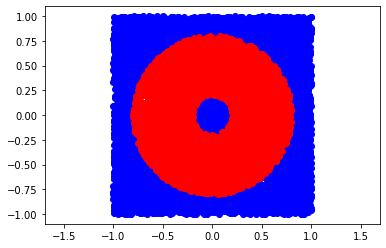

In [95]:
# Firstly, try with the separable one
ring_sep = np.genfromtxt("A2-ring/A2-ring-separable.txt", dtype=np.float32, delimiter="\t")
ring_merged = np.genfromtxt("A2-ring/A2-ring-merged.txt", dtype=np.float32, delimiter="\t")
ring_test = np.genfromtxt("A2-ring/A2-ring-test.txt", dtype=np.float32, delimiter="\t")
plot_ring_pred(ring_sep[:, :2], ring_sep[:, 2])

In [96]:
n_folds(5, ring_sep, lambda *params: run_svm({"kernel": "linear"}, *params), silent=False)

Error on one validation split: error=47.45
Error on one validation split: error=49.7
Error on one validation split: error=46.4
Error on one validation split: error=47.3
Error on one validation split: error=49.0


49.0

In [97]:
# Plotting the data
pred = run_svm({"kernel": "linear"}, ring_sep, ring_test[:, :-1])

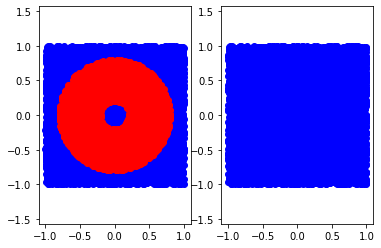

In [98]:
plt.subplot(1, 2, 1)
plot_ring_pred(ring_test[:, :2], ring_test[:, 2])
plt.subplot(1, 2, 2)
plot_ring_pred(ring_test[:, :2], pred)

As predicted, an SVM with linear kernel cannot properly separate such data

In [99]:
testing_svm_params = [
    {"kernel": "rbf", "C": 100, "gamma": 4},
    {"kernel": "rbf", "C": 1, "gamma": 1},
    {"kernel": "poly", "degree": 5},
    {"kernel": "linear"},
    {"kernel": "sigmoid"}
]

for svm_params in testing_svm_params:
    print(f"Testing with parameters: {svm_params}")
    n_folds(5, ring_sep, lambda *params: run_svm(svm_params, *params), silent=False)


Testing with parameters: {'kernel': 'rbf', 'C': 100, 'gamma': 4}
Error on one validation split: error=0.35
Error on one validation split: error=0.85
Error on one validation split: error=0.35
Error on one validation split: error=0.35
Error on one validation split: error=0.7
Testing with parameters: {'kernel': 'rbf', 'C': 1, 'gamma': 1}
Error on one validation split: error=4.15
Error on one validation split: error=3.55
Error on one validation split: error=4.0
Error on one validation split: error=3.8
Error on one validation split: error=3.5
Testing with parameters: {'kernel': 'poly', 'degree': 5}
Error on one validation split: error=48.5
Error on one validation split: error=48.1
Error on one validation split: error=46.75
Error on one validation split: error=47.6
Error on one validation split: error=48.9
Testing with parameters: {'kernel': 'linear'}
Error on one validation split: error=48.9
Error on one validation split: error=48.35
Error on one validation split: error=48.3
Error on one va

As we can see, the best performance is obtained with rbf kernel with quite high C and gamma values. We now use these values to train a final model and evaluate it on test data

Error: 0.31%


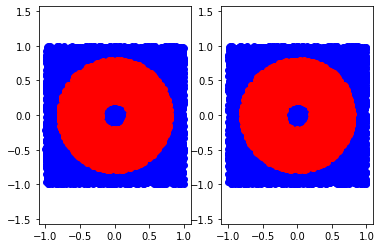

In [101]:

pred = run_svm({"kernel": "rbf", "C": 100, "gamma": 4}, ring_sep, ring_test[:, :-1])
plt.subplot(1, 2, 1)
plot_ring_pred(ring_test[:, :2], ring_test[:, 2])
plt.subplot(1, 2, 2)
plot_ring_pred(ring_test[:, :2], pred)
print(f"Error: {classification_error(pred, ring_test[:, -1])}%")

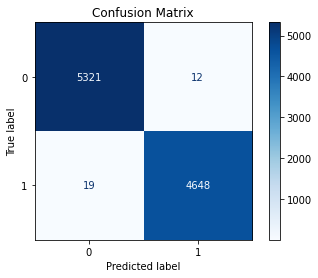

In [103]:
plot_confusion_matrix(ring_test[:, -1], pred, ['0', '1'])

Again, the radial kernel works perfectly with pretty large gamma and large C. However, these parameters need to be tuned better when dealing with merged data. As we can see in the following section, during cross validation the error is pretty large, as the data is tightly "merged" into each other. However, the test set is a subset of separable one, and on it only a small amount of samples are misclassified

In [105]:
testing_svm_params = [
    {"kernel": "rbf", "C": 100, "gamma": 4},
    {"kernel": "rbf", "C": 1, "gamma": 1},
    {"kernel": "poly", "degree": 5},
    {"kernel": "linear"},
    {"kernel": "sigmoid"}
]

for svm_params in testing_svm_params:
    print(f"Testing with parameters: {svm_params}")
    n_folds(5, ring_merged, lambda *params: run_svm(svm_params, *params), silent=False)



Testing with parameters: {'kernel': 'rbf', 'C': 100, 'gamma': 4}
Error on one validation split: error=21.7
Error on one validation split: error=21.4
Error on one validation split: error=22.45
Error on one validation split: error=21.9
Error on one validation split: error=22.05
Testing with parameters: {'kernel': 'rbf', 'C': 1, 'gamma': 1}
Error on one validation split: error=25.05
Error on one validation split: error=22.25
Error on one validation split: error=23.2
Error on one validation split: error=23.55
Error on one validation split: error=21.5
Testing with parameters: {'kernel': 'poly', 'degree': 5}
Error on one validation split: error=43.8
Error on one validation split: error=45.5
Error on one validation split: error=45.2
Error on one validation split: error=43.6
Error on one validation split: error=46.15
Testing with parameters: {'kernel': 'linear'}
Error on one validation split: error=45.4
Error on one validation split: error=45.55
Error on one validation split: error=44.45
Error

Error: 3.28%


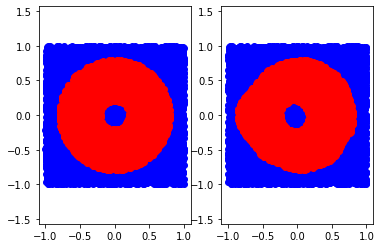

In [106]:
pred = run_svm({"kernel": "rbf", "C": 100, "gamma": 4}, ring_merged, ring_test[:, :-1])
plt.subplot(1, 2, 1)
plot_ring_pred(ring_test[:, :2], ring_test[:, 2])
plt.subplot(1, 2, 2)
plot_ring_pred(ring_test[:, :2], pred)
print(f"Error: {classification_error(pred, ring_test[:, -1])}%")

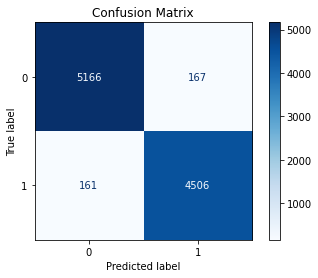

In [107]:
plot_confusion_matrix(ring_test[:, -1], pred, ['0', '1'])

Error: 2.08%


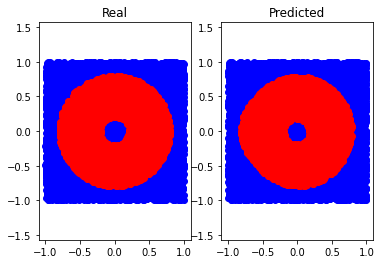

#### As expected, linear regression cannot classify the data, so the best it can do is to classify all the elements into more represented class

Error on one validation split: error=55.15
Error on one validation split: error=55.1
Error on one validation split: error=53.95
Error on one validation split: error=55.2
Error on one validation split: error=56.35
Error on one validation split: error=49.9
Error on one validation split: error=51.15
Error on one validation split: error=52.0
Error on one validation split: error=52.35
Error on one validation split: error=54.75
Error: 53.33%


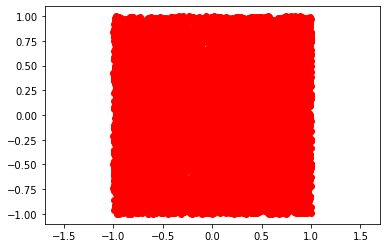

In [46]:
n_folds(5, ring_merged, run_linear_regression, silent=False)
n_folds(5, ring_sep, run_linear_regression, silent=False)
pred = run_linear_regression(ring_merged, ring_test[:, :-1])
plot_ring_pred(ring_test[:, :2], pred)
print(f"Error: {classification_error(pred, ring_test[:, -1])}%")

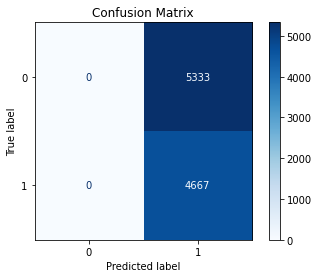

In [47]:
plot_confusion_matrix(ring_test[:, -1], pred, ['0', '1'])

When trying to train a neural network, I was experimenting with many parameters and found ones that give a good enough result. I use binary cross-entropy loss for training. Here we again evaluate different parameters for the network to select good ones. The list of parameters tried is not very large, as training the network is quite time consuming

In [54]:
# List of parameters for training the network:
# [[layers, activations], learning rate, momentum, epochs]
training_params_list = [
    [[[2, 16, 15, 1], 'tanh'], 0.006, 0.9, 30],
    [[[2, 15, 1], 'relu'], 0.01, 0.9, 30],
    [[[2, 5, 1], 'sigmoid'], 0.01, 0.9, 30],
    [[[2, 10, 1], 'tanh'], 0.01, 0.9, 30],
    [[[2, 10, 10, 1], 'relu'], 0.001, 0.5, 30],
]

for training_params in training_params_list:
    print(f"Training with params: {training_params}")
    n_folds(5, ring_sep, lambda *args: run_pytorch_network(*training_params, *args), silent=False)

Error on one validation split: error=5.75
Error on one validation split: error=5.2
Error on one validation split: error=4.9
Error on one validation split: error=5.05
Error on one validation split: error=5.45
Training with params: [[[2, 5, 1], 'sigmoid'], 0.01, 0.9, 30]
Error on one validation split: error=15.7
Error on one validation split: error=14.3
Error on one validation split: error=14.65
Error on one validation split: error=14.7
Error on one validation split: error=14.4
Training with params: [[[2, 10, 1], 'tanh'], 0.01, 0.9, 30]
Error on one validation split: error=6.8
Error on one validation split: error=9.2
Error on one validation split: error=9.2
Error on one validation split: error=8.9
Error on one validation split: error=9.4
Training with params: [[[2, 10, 10, 1], 'relu'], 0.001, 0.5, 30]
Error on one validation split: error=26.65
Error on one validation split: error=24.35
Error on one validation split: error=25.65
Error on one validation split: error=28.15
Error on one vali

Now we choose good performing parameters from above and train the full network on it

In [0]:
pred = run_pytorch_network([[2, 16, 15, 1], 'tanh'], 0.006, 0.9, 30, ring_sep.copy(), ring_test[:, :-1], real_outputs=True)

0.9992035071079879


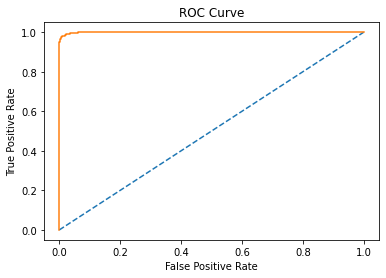

Optimal threshold point: 0.548506498336792


In [64]:
optimal_threshold = plot_roc_curve(ring_test[:, -1], pred)[0]
print("Optimal threshold point:", optimal_threshold)

The curve is almost perfect. We can keep the

Error: 1.73%


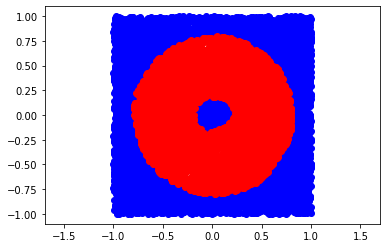

In [65]:
pred[pred < optimal_threshold] = 0
pred[pred != 0] = 1
plot_ring_pred(ring_test[:, :2], pred)
print(f"Error: {classification_error(pred, ring_test[:, -1])}%")

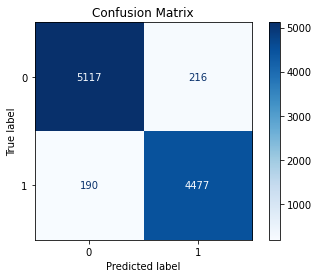

In [75]:
plot_confusion_matrix(ring_test[:, -1], pred, ['0', '1'])

On not linearly separable data the network pretty quickly converges to a point where both training and validation losses don't change much. Maybe with some parameters the performance would be better, but even now the error is a couple of percents, which is not much. Now we try to repeat the same procedure with not separable dataset

In [66]:
# List of parameters for training the network:
# [[layers, activations], learning rate, momentum, epochs]
training_params_list = [
    [[[2, 16, 15, 1], 'tanh'], 0.006, 0.9, 30],
    [[[2, 16, 15, 1], 'relu'], 0.01, 0.9, 20],
    [[[2, 5, 1], 'sigmoid'], 0.01, 0.9, 20],
    [[[2, 10, 1], 'tanh'], 0.01, 0.9, 25],
    [[[2, 10, 10, 1], 'relu'], 0.001, 0.5, 30],
]
for training_params in training_params_list:
    print(f"Training with params: {training_params}")
    n_folds(5, ring_merged, lambda *args: run_pytorch_network(*training_params, *args), silent=False)

Training with params: [[[2, 16, 15, 1], 'tanh'], 0.006, 0.9, 30]
Error on one validation split: error=23.7
Error on one validation split: error=23.65
Error on one validation split: error=21.95
Error on one validation split: error=23.45
Error on one validation split: error=23.35
Training with params: [[[2, 15, 1], 'relu'], 0.01, 0.9, 20]
Error on one validation split: error=23.05
Error on one validation split: error=22.05
Error on one validation split: error=24.2
Error on one validation split: error=24.7
Error on one validation split: error=22.4
Training with params: [[[2, 5, 1], 'sigmoid'], 0.01, 0.9, 20]
Error on one validation split: error=37.5
Error on one validation split: error=35.0
Error on one validation split: error=38.55
Error on one validation split: error=34.85
Error on one validation split: error=34.15
Training with params: [[[2, 10, 1], 'tanh'], 0.01, 0.9, 25]
Error on one validation split: error=22.6
Error on one validation split: error=25.4
Error on one validation split:

In [72]:
pred = run_pytorch_network([[2, 16, 15, 1], 'relu'], 0.01, 0.9, 20, ring_merged.copy(), ring_test[:, :-1], silent=True, real_outputs=True)

0.9948218721030252


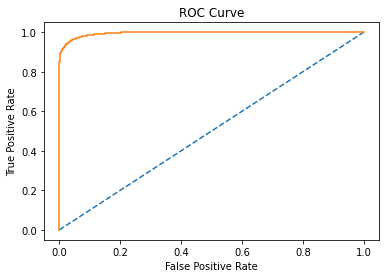

Optimal threshold point: 0.4583946764469147


In [73]:
optimal_threshold = plot_roc_curve(ring_test[:, -1], pred)[0]
print("Optimal threshold point:", optimal_threshold)

The curve looks very dnice again

Error: 4.06%


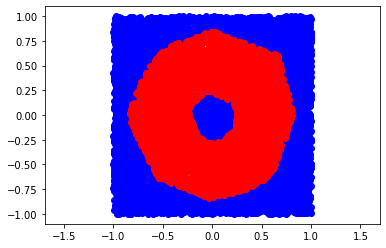

In [74]:
pred[pred < optimal_threshold] = 0
pred[pred != 0] = 1
plot_ring_pred(ring_test[:, :2], pred)
print(f"Error: {classification_error(pred, ring_test[:, -1])}%")

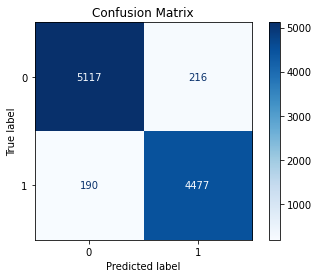

In [76]:
plot_confusion_matrix(ring_test[:, -1], pred, ['0', '1'])

### Trying with "bank" dataset

In [17]:
bank_full = np.genfromtxt("A2-bank/bank-full-preprocessed.csv", dtype=np.float32, skip_header=1, delimiter=',')

# Split into test and train only once so we compare each model in the same conditions
np.random.seed(42)
np.random.shuffle(bank_full)

split_index = int(0.8 * bank_full.shape[0])
bank_train = bank_full[:split_index, :]
bank_test = bank_full[split_index:, :]

print(bank_train.shape, bank_test.shape)

(32950, 23) (8238, 23)


For this dataset, we will need PCA transformation for visualization. We fit it on the whole data, and will reuse for visualization. As we can see, more than a half of variance can be explained with just two components. It's a lot, but some almost half of the variance will be not visualized, which can lead to misinterpretation of plots

PCA explained variance ratio: [0.36117733 0.154147  ]


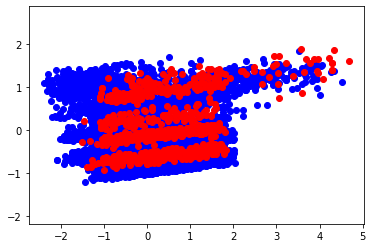

In [108]:
pca_bank = PCA(n_components=2)
pca_bank.fit(bank_full[:, :-1])
print("PCA explained variance ratio:", pca_bank.explained_variance_ratio_)

def plot_bank_pred(data, pred_):
    data = pca_bank.transform(data)

    plt.scatter(data[pred_ == 0, 0], data[pred_ == 0, 1], color='blue')
    plt.scatter(data[pred_ == 1, 0], data[pred_ == 1, 1], color='red')
    plt.axis('equal')

# Plot distribution of test data with these PCA
plot_bank_pred(bank_test[:, :-1], bank_test[:, -1])

On this dataset, a simple linear regression works almost perfectly. In both cross validation and training on the whole training dataset, the error is below 0.36%. When training on test data, only 14 samples from the test dataset are misclassified

In [109]:
n_folds(5, bank_train, run_linear_regression, silent=False)
pred = run_linear_regression_get_real_scores(bank_train, bank_test[:, :-1])

Error on one validation split: error=0.24279210925644917
Error on one validation split: error=0.18209408194233687
Error on one validation split: error=0.13657056145675264
Error on one validation split: error=0.25796661608497723
Error on one validation split: error=0.18209408194233687


The ROC curve is also almost perfect

0.9994197234336922


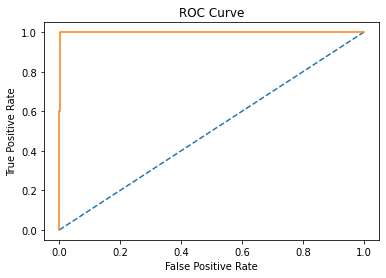

Optimal threshold point: 0.9763761162757874


In [110]:
optimal_threshold = plot_roc_curve(bank_test[:, -1], pred)[0]
print("Optimal threshold point:", optimal_threshold)

Error: 0.16994416120417577%
14.0


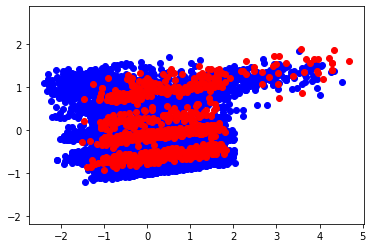

In [111]:
pred[pred < optimal_threshold] = 0
pred[pred != 0] = 1
plot_bank_pred(bank_test[:, :-1], pred)
print(f"Error: {classification_error(pred, bank_test[:, -1])}%")
print(np.sum(np.abs(pred - bank_test[:, -1])))


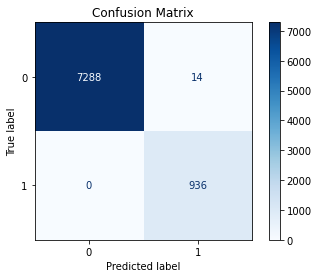

In [112]:
plot_confusion_matrix(bank_test[:, -1], pred, ['0', '1'])

Let's now try to train an SVM on this data. As the linear regression works very well, a linear kernel should show a good performance too. As we can see, the performance is very similar. I was experimenting with different kernels here, but they just give the same result as the linear one. We don't try the sigmoid kernel, as the computation with it takes a lot of time, and the performance is very poor

In [118]:

testing_svm_params = [
    {"kernel": "rbf", "C": 1, "gamma": 1},
    {"kernel": "poly", "degree": 5},
    {"kernel": "linear"},
]

for svm_params in testing_svm_params:
    print(f"Testing with parameters: {svm_params}")
    n_folds(5, bank_train, lambda *params: run_svm(svm_params, *params), silent=False)


Testing with parameters: {'kernel': 'rbf', 'C': 1, 'gamma': 1}
Error on one validation split: error=0.24279210925644917
Error on one validation split: error=0.2276176024279211
Error on one validation split: error=0.18209408194233687
Error on one validation split: error=0.2731411229135053
Error on one validation split: error=0.25796661608497723
Testing with parameters: {'kernel': 'poly', 'degree': 5}
Error on one validation split: error=0.2276176024279211
Error on one validation split: error=0.25796661608497723
Error on one validation split: error=0.212443095599393
Error on one validation split: error=0.2276176024279211
Error on one validation split: error=0.15174506828528073
Testing with parameters: {'kernel': 'linear'}
Error on one validation split: error=0.19726858877086495
Error on one validation split: error=0.19726858877086495
Error on one validation split: error=0.30349013657056145
Error on one validation split: error=0.2276176024279211
Error on one validation split: error=0.0758

In [131]:
pred = run_svm({"kernel": "poly", "degree": 5}, bank_train, bank_test[:, :-1])

Error: 0.16994416120417577%
14.0


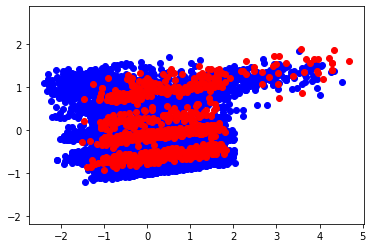

In [132]:
plot_bank_pred(bank_test[:, :-1], pred)
print(f"Error: {classification_error(pred, bank_test[:, -1])}%")
print(np.sum(np.abs(pred - bank_test[:, -1])))

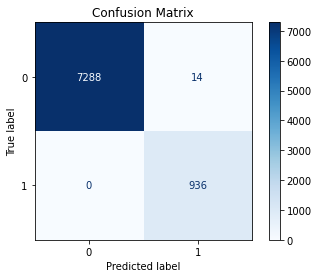

In [133]:
plot_confusion_matrix(bank_test[:, -1], pred, ['0', '1'])

Now trying with a neural network. The network with only 1 hidden layer and tanh activation shows very good results here, and pretty quickly converges to a good error, close to the one obtained from linear regression. NOTE: this takes quite a long time on the full dataset

In [125]:
# List of parameters for training the network:
# [[layers, activations], learning rate, momentum, epochs]
training_params_list = [
    [[[22, 16, 15, 1], 'tanh'], 0.006, 0.9, 30],
    [[[22, 16, 15, 1], 'relu'], 0.01, 0.9, 20],
    [[[22, 5, 1], 'sigmoid'], 0.01, 0.9, 20],
    [[[22, 10, 1], 'tanh'], 0.01, 0.9, 25],
    [[[22, 10, 10, 1], 'relu'], 0.001, 0.5, 30],
]
for training_params in training_params_list:
    print(f"Training with params: {training_params}")
    n_folds(5, bank_train, lambda *args: run_pytorch_network(*training_params, *args), silent=False)



Training with params: [[[22, 16, 15, 1], 'tanh'], 0.006, 0.9, 30]
Error on one validation split: error=0.18209408194233687
Error on one validation split: error=0.15174506828528073
Error on one validation split: error=0.212443095599393
Error on one validation split: error=0.24279210925644917
Error on one validation split: error=0.212443095599393
Training with params: [[[22, 16, 15, 1], 'relu'], 0.01, 0.9, 20]
Error on one validation split: error=0.15174506828528073
Error on one validation split: error=0.2276176024279211
Error on one validation split: error=0.2731411229135053
Error on one validation split: error=0.18209408194233687
Error on one validation split: error=0.1669195751138088
Training with params: [[[22, 5, 1], 'sigmoid'], 0.01, 0.9, 20]
Error on one validation split: error=0.18209408194233687
Error on one validation split: error=0.15174506828528073
Error on one validation split: error=0.1669195751138088
Error on one validation split: error=0.212443095599393
Error on one valid

In [126]:
pred = run_pytorch_network([[22, 16, 15, 1], 'tanh'], 0.006, 0.9, 30, bank_train.copy(), bank_test[:, :-1], silent=False, real_outputs=True)

Epoch: 0. 
Loss on training: 0.06372775923503914 
Loss on validation: 0.009384536184370518 
##########
Epoch: 1. 
Loss on training: 0.010920509252189922 
Loss on validation: 0.008690385147929192 
##########
Epoch: 2. 
Loss on training: 0.010572723575051304 
Loss on validation: 0.010246132500469685 
##########
Epoch: 3. 
Loss on training: 0.01041190536908014 
Loss on validation: 0.008433989249169827 
##########
Epoch: 4. 
Loss on training: 0.010341309166686902 
Loss on validation: 0.008453723043203354 
##########
Epoch: 5. 
Loss on training: 0.010270837551135562 
Loss on validation: 0.008762490935623646 
##########
Epoch: 6. 
Loss on training: 0.010167080236069095 
Loss on validation: 0.008995071984827518 
##########
Epoch: 7. 
Loss on training: 0.01027557622163204 
Loss on validation: 0.008584103547036648 
##########
Epoch: 8. 
Loss on training: 0.010126326362429314 
Loss on validation: 0.00851076003164053 
##########
Epoch: 9. 
Loss on training: 0.009996945544939444 
Loss on validatio

0.9993701233943633


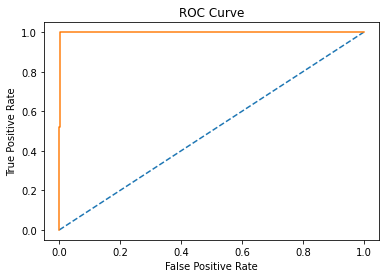

Optimal threshold point: 0.8899574279785156


In [127]:
optimal_threshold = plot_roc_curve(bank_test[:, -1], pred)[0]
print("Optimal threshold point:", optimal_threshold)

Error: 0.19422189851905802%
16.0


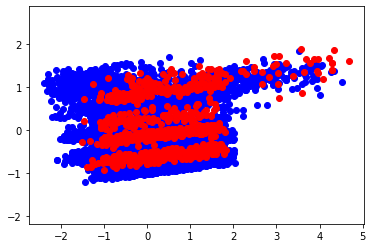

In [129]:
pred[pred < optimal_threshold] = 0
pred[pred != 0] = 1
plot_bank_pred(bank_test[:, :-1], pred)
print(f"Error: {classification_error(pred, bank_test[:, -1])}%")
print(np.sum(np.abs(pred - bank_test[:, -1])))


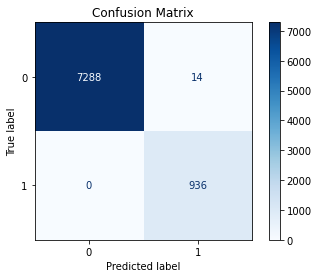

In [135]:
plot_confusion_matrix(bank_test[:, -1], pred, ['0', '1'])

# Rice dataset

In [23]:
rice_data = np.genfromtxt("A2-Rice/rice-preprocessed.csv", dtype=np.float32, skip_header=1, delimiter=',')

# Split into test and train only once so we compare each model in the same conditions
np.random.seed(42)
np.random.shuffle(rice_data)

split_index = int(0.8 * rice_data.shape[0])
rice_train = rice_data[:split_index, :]
rice_test = rice_data[split_index:, :]

print(rice_train.shape, rice_test.shape)

(3048, 8) (762, 8)


In [24]:
n_folds(5, rice_train, run_linear_regression, silent=False)
pred = run_linear_regression(rice_train, rice_test[:, :-1])
print(f"Error: {classification_error(rice_test[:, -1], pred)}%")
print(np.sum(np.abs(pred - rice_test[:, -1])))

Error on one validation split: error=17.733990147783253
Error on one validation split: error=19.18032786885246
Error on one validation split: error=20.689655172413794
Error on one validation split: error=21.311475409836067
Error on one validation split: error=20.16393442622951
Error: 22.178477690288712%
169.0


Error on one validation split: error=21.346469622331693
Error on one validation split: error=22.62295081967213
Error on one validation split: error=18.39080459770115
Error on one validation split: error=20.0
Error on one validation split: error=18.0327868852459
Error: 20.927188903328002%
0.9804643044161285


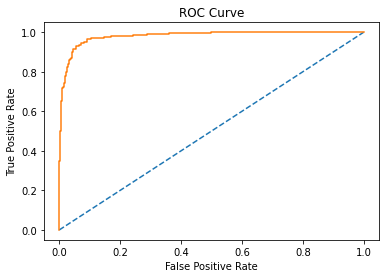

In [25]:
n_folds(5, rice_train, run_linear_regression, silent=False)
pred = run_linear_regression_get_real_scores(rice_train, rice_test[:, :-1])
print(f"Error: {classification_error(rice_test[:, -1], pred)}%")
plot_roc_curve(rice_test[:, -1], pred)

#print(rice_test[:, -1])

On this dataset, a simple linear regression works really good. In both cross validation and training on the whole training dataset, the error is below 8.22%. In the test data there are 46 samples of 762 missclassified

Let's now try to train an SVM on this data. As the linear regression works well, a linear kernel should show a good performance too. As we can see, the performance is very similar. I was experimenting with different kernels here, but they just give the same result as the linear one

In [26]:
n_folds(5, rice_train, lambda *params: run_svm({"kernel": "rbf"}, *params), silent=False)
pred = run_svm({"kernel": "linear"}, rice_train, rice_test[:, :-1])
print(f"Error: {classification_error(rice_test[:, -1], pred)}%")

Error on one validation split: error=8.70279146141215
Error on one validation split: error=7.704918032786885
Error on one validation split: error=7.389162561576355
Error on one validation split: error=6.065573770491803
Error on one validation split: error=8.360655737704919
Error: 6.692913385826771%


Now trying with a neural network. The network with only 1 hidden layer and tanh activation shows very good results here, and pretty quickly converges to a good error, close to the one obtained from linear regression

In [27]:
nn_params = [[7, 7,4,10, 1], 'tanh']

n_folds(5, rice_train, lambda *args: run_pytorch_network(nn_params, 0.001, 100, *args), silent=False)
pred = run_pytorch_network(nn_params, 0.001, 100, rice_train.copy(), rice_test[:, :-1], silent=False)
print(f"Error: {classification_error(pred, rice_test[:, -1])}%")

Error on one validation split: error=6.568144499178982
Error on one validation split: error=6.885245901639344
Error on one validation split: error=9.523809523809524
Error on one validation split: error=6.557377049180328
Error on one validation split: error=5.737704918032787
Epoch: 0. 
Loss on training: 0.599172416783164 
Loss on validation: 0.4570279121398926 
##########
Epoch: 1. 
Loss on training: 0.34984680899867304 
Loss on validation: 0.2603173851966858 
##########
Epoch: 2. 
Loss on training: 0.2421764362864043 
Loss on validation: 0.20978333055973053 
##########
Epoch: 3. 
Loss on training: 0.215974216445238 
Loss on validation: 0.19597874581813812 
##########
Epoch: 4. 
Loss on training: 0.2082554739535836 
Loss on validation: 0.19164282083511353 
##########
Epoch: 5. 
Loss on training: 0.2057216137249038 
Loss on validation: 0.18997415900230408 
##########
Epoch: 6. 
Loss on training: 0.2035845070310826 
Loss on validation: 0.1882784515619278 
##########
Epoch: 7. 
Loss on tra